In [1]:
!pip install catboost
!pip install shap
!pip install pyLDAvis
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 76 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 9.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 25.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=c19bc59645eddae54e6d90638db42344b2d2dc033ebb50544790a25d590a64c7
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.d

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis.sklearn
from itertools import combinations
from category_encoders import * 

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/iolib/foreign.py:633: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work

In [74]:
train = pd.read_csv('/content/drive/MyDrive/ml competition/av-job-a-thon-june22/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ml competition/av-job-a-thon-june22/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/ml competition/av-job-a-thon-june22/sample_submission.csv')

In [75]:
train.head()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [76]:
train['created_at'] = pd.to_datetime(train['created_at'])
test['created_at'] = pd.to_datetime(test['created_at'])

train['signup_date'] = pd.to_datetime(train['signup_date'])
test['signup_date'] = pd.to_datetime(test['signup_date'])

In [77]:
train[train['signup_date']<train['created_at']]

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0
5,6,2021-01-01,3,4,3.0,2019-07-02,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39148,39149,2021-12-31,9,6,NaN,2020-04-12,0,0,0,0,0,1,0,0,0,0,1,0,0
39149,39150,2021-12-31,1,5,3.0,2021-05-20,0,0,0,0,0,0,1,0,0,0,0,0,0
39154,39155,2021-12-31,7,11,3.0,2020-11-03,0,0,0,0,0,1,0,0,0,0,0,0,0
39156,39157,2021-12-31,11,11,2.0,2017-10-19,1,0,0,0,1,1,1,0,0,0,0,0,0


In [78]:
train.shape

(39161, 19)

In [79]:
train.groupby('products_purchased').apply(lambda data: data['buy'].sum()*100/data['buy'].count())

products_purchased
1.0     6.642877
2.0     4.319386
3.0     5.055732
4.0    10.335196
dtype: float64

In [80]:
train.shape

(39161, 19)

In [81]:
train.head()

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [82]:
train['products_purchased'].fillna(0,inplace=True)
test['products_purchased'].fillna(0,inplace=True)

In [83]:
train['products_purchased'] = train['products_purchased'].astype(int)
test['products_purchased'] = test['products_purchased'].astype(int)

In [84]:
# train['temp'] = train['campaign_var_1'].astype(str) + train['products_purchased'].astype(str)

In [85]:
# train.groupby('temp').apply(lambda data: data['buy'].sum()*100/data['buy'].count())

In [86]:
train['created_at'].dt.dayofweek

0        4
1        4
2        4
3        4
4        4
        ..
39156    4
39157    4
39158    4
39159    4
39160    4
Name: created_at, Length: 39161, dtype: int64

In [87]:
train['day_diff'] = (train['created_at'] - train['signup_date']).dt.days

In [88]:
train['day_diff'].value_counts()

 129.0     47
-80.0      43
-63.0      41
 147.0     40
 91.0      38
           ..
 1520.0     1
 1225.0     1
 1187.0     1
 1697.0     1
 1830.0     1
Name: day_diff, Length: 1940, dtype: int64

In [89]:
train['day_diff'].isnull().sum()

15113

In [90]:
train[train['day_diff']==0].shape

(22, 20)

In [91]:
cat_features = ['campaign_var_1',
 'campaign_var_2',
 'products_purchased',
 'user_activity_var_2',
 'user_activity_var_4',
 'user_activity_var_5',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_9',
 'user_activity_var_11',
 'created_at_dayofweek',
 'signup_dayofweek',
 'created_at_month',
 'signup_month',
 'signup_year',
 'signup_day',
 'signup_null',
 'signup_before_created',
 'signup_week',
 'signup_quarter'
 ]

In [92]:
train['signup_date'].dt.isocalendar().week.value_counts()

6     568
9     563
11    551
7     547
2     533
4     532
8     530
10    528
3     515
49    514
1     504
12    503
47    498
43    491
52    488
42    487
48    482
38    482
45    481
44    480
41    479
51    477
46    475
28    475
37    472
50    467
33    459
5     457
26    455
40    450
35    440
32    439
13    437
34    431
23    428
21    427
36    424
39    422
30    420
24    418
29    414
17    405
19    401
27    395
31    393
25    392
22    389
16    387
18    375
15    373
20    373
14    352
53    170
Name: week, dtype: Int64

In [93]:
def transformer(dataframe, cat_features):
  dataframe['created_at_dayofweek'] = dataframe['created_at'].dt.dayofweek
  dataframe['signup_dayofweek'] = dataframe['signup_date'].dt.dayofweek
  dataframe['signup_dayofweek'].fillna(-1,inplace=True)
  dataframe['created_at_month'] = dataframe['created_at'].dt.month
  dataframe['signup_month'] = dataframe['signup_date'].dt.month
  dataframe['signup_month'].fillna(-1,inplace=True)
  dataframe['signup_year'] = dataframe['signup_date'].dt.year
  dataframe['signup_year'].fillna(-1,inplace=True)
  dataframe['signup_day'] = dataframe['signup_date'].dt.day
  dataframe['signup_day'].fillna(-1,inplace=True)
  dataframe['signup_week'] = dataframe['signup_date'].dt.isocalendar().week
  dataframe['signup_week'] = dataframe['signup_week'].astype(float)
  dataframe['signup_week'].fillna(-1,inplace=True)
  dataframe['signup_quarter'] = dataframe['signup_date'].dt.quarter
  dataframe['signup_quarter'].fillna(-1,inplace=True)
  dataframe['day_diff'] = (dataframe['created_at'] - dataframe['signup_date']).dt.days
  dataframe['day_diff'].fillna(0,inplace=True)
  dataframe['products_purchased'] = dataframe['products_purchased'].astype(int)
  dataframe['signup_null'] = np.where(dataframe['signup_date'].isnull(),1,0)
  dataframe['signup_before_created'] = np.where((dataframe['signup_date']<dataframe['created_at'])&(dataframe['signup_date'].notnull()),1,0)
  for f in cat_features:
    dataframe[f] = dataframe[f].astype(int)
  return dataframe

In [94]:
train = transformer(train, cat_features)
test = transformer(test, cat_features)

In [95]:
buy_rate = lambda data: data['buy'].sum()*100/data['buy'].count()

In [96]:
train.columns

Index(['id', 'created_at', 'campaign_var_1', 'campaign_var_2',
       'products_purchased', 'signup_date', 'user_activity_var_1',
       'user_activity_var_2', 'user_activity_var_3', 'user_activity_var_4',
       'user_activity_var_5', 'user_activity_var_6', 'user_activity_var_7',
       'user_activity_var_8', 'user_activity_var_9', 'user_activity_var_10',
       'user_activity_var_11', 'user_activity_var_12', 'buy', 'day_diff',
       'created_at_dayofweek', 'signup_dayofweek', 'created_at_month',
       'signup_month', 'signup_year', 'signup_day', 'signup_week',
       'signup_quarter', 'signup_null', 'signup_before_created'],
      dtype='object')

In [97]:
user_list = ['products_purchased','user_activity_var_1',
       'user_activity_var_2', 'user_activity_var_3', 'user_activity_var_4',
       'user_activity_var_5', 'user_activity_var_6', 'user_activity_var_7',
       'user_activity_var_8', 'user_activity_var_9', 'user_activity_var_10',
       'user_activity_var_11', 'user_activity_var_12',]

In [98]:
comb = combinations(user_list, 2)
 
# Print the obtained combinations
for i, j in enumerate(list(comb)):
  train[f'var{i}'] = train[j[0]].astype(str) + train[j[1]].astype(str)
  test[f'var{i}'] = test[j[0]].astype(str) + test[j[1]].astype(str)

In [99]:
for col in cat_features:
  display(col)
  display(train.groupby(col).apply(buy_rate))

'campaign_var_1'

campaign_var_1
1     6.089140
2     7.142857
3     7.293869
4     6.893977
5     6.576355
6     5.614381
7     5.298190
8     4.461403
9     3.593859
10    2.550167
11    2.562734
12    1.649485
13    1.133144
14    0.280112
15    0.657895
16    0.000000
dtype: float64

'campaign_var_2'

campaign_var_2
1     3.735144
2     5.816555
3     5.896635
4     7.785426
5     7.238095
6     6.354457
7     5.354532
8     4.029851
9     2.883800
10    1.479547
11    0.496454
12    0.394218
13    0.284900
14    0.000000
15    0.000000
dtype: float64

'products_purchased'

products_purchased
0     4.997370
1     6.642877
2     4.319386
3     5.055732
4    10.335196
dtype: float64

'user_activity_var_2'

user_activity_var_2
0      4.460384
1    100.000000
dtype: float64

'user_activity_var_4'

user_activity_var_4
0     4.166667
1    85.746102
dtype: float64

'user_activity_var_5'

user_activity_var_5
0      3.609674
1     13.251991
2    100.000000
dtype: float64

'user_activity_var_7'

user_activity_var_7
0    5.48909
1    4.15465
2    0.00000
dtype: float64

'user_activity_var_8'

user_activity_var_8
0    6.086661
1    0.439560
2    0.000000
dtype: float64

'user_activity_var_9'

user_activity_var_9
0      4.003823
1    100.000000
dtype: float64

'user_activity_var_11'

user_activity_var_11
0      2.699375
1     11.433892
2     98.654709
3    100.000000
4    100.000000
dtype: float64

'created_at_dayofweek'

created_at_dayofweek
0    4.813117
1    5.540516
2    4.838710
3    5.092924
4    5.330223
5    4.829443
6    5.275311
dtype: float64

'signup_dayofweek'

signup_dayofweek
-1    0.165420
 0    8.323564
 1    7.886155
 2    8.079625
 3    8.402878
 4    7.392317
 5    9.088311
 6    8.233925
dtype: float64

'created_at_month'

created_at_month
1     5.188679
2     6.380028
3     5.224609
4     5.432937
5     5.180422
6     5.688530
7     5.593220
8     5.446996
9     5.360577
10    4.695838
11    4.229283
12    4.417178
dtype: float64

'signup_month'

signup_month
-1     0.165420
 1     9.622887
 2     8.508649
 3     6.769494
 4     8.497537
 5     8.140192
 6     8.126411
 7     7.907222
 8     8.195021
 9     7.544225
 10    8.512629
 11    8.102863
 12    8.484006
dtype: float64

'signup_year'

signup_year
-1        0.165420
 2015    84.615385
 2016    37.096774
 2017    23.270440
 2018    14.118565
 2019    10.030145
 2020     7.359125
 2021     6.895449
 2022     6.615315
dtype: float64

'signup_day'

signup_day
-1     0.165420
 1     8.194622
 2     8.678238
 3     9.665871
 4     7.180157
 5     7.988981
 6     9.630607
 7     8.596713
 8     8.955224
 9     7.820513
 10    8.375635
 11    9.464508
 12    8.763505
 13    8.655126
 14    7.035176
 15    8.557457
 16    7.522698
 17    8.383961
 18    7.759700
 19    6.849315
 20    9.669811
 21    7.731959
 22    9.125475
 23    9.220779
 24    6.088083
 25    8.395062
 26    8.254717
 27    7.779172
 28    7.750953
 29    6.594886
 30    7.725322
 31    6.960557
dtype: float64

'signup_null'

signup_null
0    8.204424
1    0.165420
dtype: float64

'signup_before_created'

signup_before_created
0    1.839935
1    8.865911
dtype: float64

'signup_week'

signup_week
-1      0.165420
 1     10.912698
 2      8.630394
 3      9.708738
 4     10.150376
 5      7.877462
 6      8.098592
 7      7.312614
 8     10.566038
 9      6.571936
 10     7.575758
 11     6.715064
 12     7.355865
 13     5.491991
 14    11.931818
 15     7.774799
 16     9.043928
 17     6.419753
 18     7.733333
 19     7.231920
 20     9.115282
 21     8.196721
 22     8.226221
 23     9.813084
 24     7.655502
 25     7.397959
 26     7.252747
 27     7.594937
 28     9.052632
 29     7.004831
 30     7.857143
 31     7.888041
 32     7.517084
 33    10.457516
 34     6.496520
 35     9.545455
 36     7.075472
 37     8.050847
 38     7.883817
 39     6.635071
 40     6.888889
 41     8.559499
 42     8.213552
 43    10.183299
 44     6.666667
 45     9.771310
 46     6.315789
 47     9.437751
 48     7.468880
 49    11.867704
 50     6.638116
 51     8.176101
 52     7.581967
 53     8.823529
dtype: float64

'signup_quarter'

signup_quarter
-1    0.165420
 1    8.289086
 2    8.247822
 3    7.882373
 4    8.370044
dtype: float64

In [100]:
train

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,...,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77
0,1,2021-01-01,1,2,2,2020-09-24,0,0,0,0,...,10,10,10,10,00,00,00,00,00,00
1,2,2021-01-01,2,1,2,2020-09-19,1,0,1,0,...,00,00,00,00,00,00,00,00,00,00
2,3,2021-01-01,9,3,3,2021-08-11,1,0,0,0,...,00,00,00,00,00,00,00,00,00,00
3,4,2021-01-01,6,7,2,2017-10-04,0,0,0,0,...,00,00,00,00,00,00,00,00,00,00
4,5,2021-01-01,4,6,0,2020-06-08,0,0,0,0,...,00,00,01,00,00,01,00,01,00,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39156,39157,2021-12-31,11,11,2,2017-10-19,1,0,0,0,...,00,00,00,00,00,00,00,00,00,00
39157,39158,2021-12-31,3,9,3,NaT,0,0,0,0,...,00,00,00,00,00,00,00,00,00,00
39158,39159,2021-12-31,8,7,2,NaT,1,0,0,0,...,00,00,00,00,00,00,00,00,00,00
39159,39160,2021-12-31,7,12,2,NaT,0,0,0,0,...,00,00,01,00,00,01,00,01,00,10


In [101]:
train.columns.tolist()

['id',
 'created_at',
 'campaign_var_1',
 'campaign_var_2',
 'products_purchased',
 'signup_date',
 'user_activity_var_1',
 'user_activity_var_2',
 'user_activity_var_3',
 'user_activity_var_4',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_9',
 'user_activity_var_10',
 'user_activity_var_11',
 'user_activity_var_12',
 'buy',
 'day_diff',
 'created_at_dayofweek',
 'signup_dayofweek',
 'created_at_month',
 'signup_month',
 'signup_year',
 'signup_day',
 'signup_week',
 'signup_quarter',
 'signup_null',
 'signup_before_created',
 'var0',
 'var1',
 'var2',
 'var3',
 'var4',
 'var5',
 'var6',
 'var7',
 'var8',
 'var9',
 'var10',
 'var11',
 'var12',
 'var13',
 'var14',
 'var15',
 'var16',
 'var17',
 'var18',
 'var19',
 'var20',
 'var21',
 'var22',
 'var23',
 'var24',
 'var25',
 'var26',
 'var27',
 'var28',
 'var29',
 'var30',
 'var31',
 'var32',
 'var33',
 'var34',
 'var35',
 'var36',
 'var37',
 'var38',
 'var39',
 'var40

In [121]:
cat_features2 = [
 'user_activity_var_2',
 'user_activity_var_4',
 'user_activity_var_5',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_9',
 'user_activity_var_11',
 'created_at_dayofweek',
 'created_at_month',
'var0',
 'var1',
 'var2',
 'var3',
 'var4',
 'var5',
 'var6',
 'var7',
 'var8',
 'var9',
 'var10',
 'var11',
 'var12',
 'var13',
 'var14',
 'var15',
 'var16',
 'var17',
 'var18',
 'var19',
 'var20',
 'var21',
 'var22',
 'var23',
 'var24',
 'var25',
 'var26',
 'var27',
 'var28',
 'var29',
 'var30',
 'var31',
 'var32',
 'var33',
 'var34',
 'var35',
 'var36',
 'var37',
 'var38',
 'var39',
 'var40',
 'var41',
 'var42',
 'var43',
 'var44',
 'var45',
 'var46',
 'var47',
 'var48',
 'var49',
 'var50',
 'var51',
 'var52',
 'var53',
 'var54',
 'var55',
 'var56',
 'var57',
 'var58',
 'var59',
 'var60',
 'var61',
 'var62',
 'var63',
 'var64',
 'var65',
 'var66',
 'var67',
 'var68',
 'var69',
 'var70',
 'var71',
 'var72',
 'var73',
 'var74',
 'var75',
 'var76',
 'var77']

In [103]:
train.drop(columns = ['user_activity_var_1', 'user_activity_var_3', 'user_activity_var_6', 'user_activity_var_10', 
                      'user_activity_var_12', 'created_at', 'signup_date'], inplace=True)
test.drop(columns = ['user_activity_var_1', 'user_activity_var_3', 'user_activity_var_6', 'user_activity_var_10', 
                      'user_activity_var_12', 'created_at', 'signup_date'], inplace=True)

In [104]:
X = train.drop(columns = ['buy'])
y = train['buy']

In [105]:
X.isnull().sum()

id                     0
campaign_var_1         0
campaign_var_2         0
products_purchased     0
user_activity_var_2    0
                      ..
var73                  0
var74                  0
var75                  0
var76                  0
var77                  0
Length: 100, dtype: int64

In [106]:
test.isnull().sum()

id                     0
campaign_var_1         0
campaign_var_2         0
products_purchased     0
user_activity_var_2    0
                      ..
var73                  0
var74                  0
var75                  0
var76                  0
var77                  0
Length: 100, dtype: int64

In [107]:
X.shape

(39161, 100)

In [108]:
test.shape

(13184, 100)

In [109]:
set(X.columns) - set(test.columns)

set()

In [110]:
X.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [111]:
test = test[X.columns]

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, stratify = y,random_state=42)

In [114]:
X_train

,id,campaign_var_1,campaign_var_2,products_purchased,user_activity_var_2,user_activity_var_4,user_activity_var_5,user_activity_var_7,user_activity_var_8,user_activity_var_9,...,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77
31678,31679,11,7,0,0,0,0,0,1,0,...,10,10,10,10,00,00,00,00,00,00
4967,4968,10,4,3,0,0,0,0,0,0,...,00,00,00,00,00,00,00,00,00,00
35958,35959,8,9,3,0,0,0,1,1,0,...,10,10,10,10,00,00,00,00,00,00
30133,30134,4,6,0,0,0,0,0,0,0,...,00,00,00,00,00,00,00,00,00,00
31358,31359,6,6,2,0,0,0,1,0,0,...,00,00,01,00,00,01,00,01,00,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,6745,15,10,0,0,0,0,1,0,0,...,00,00,00,00,00,00,00,00,00,00
1631,1632,9,6,3,0,0,0,0,0,0,...,00,00,00,00,00,00,00,00,00,00
33117,33118,3,7,0,0,0,0,1,0,0,...,00,00,00,00,00,00,00,00,00,00
17693,17694,3,3,0,0,0,0,1,0,0,...,00,00,01,00,00,01,00,01,00,10


In [115]:
X_test

,id,campaign_var_1,campaign_var_2,products_purchased,user_activity_var_2,user_activity_var_4,user_activity_var_5,user_activity_var_7,user_activity_var_8,user_activity_var_9,...,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77
32768,32769,2,3,2,0,0,0,0,0,0,...,00,00,01,00,00,01,00,01,00,10
37536,37537,1,7,0,0,0,1,1,0,0,...,00,00,00,00,00,00,00,00,00,00
35476,35477,6,6,0,0,0,0,1,1,0,...,10,10,11,10,00,01,00,01,00,10
3056,3057,9,3,3,0,0,0,1,0,0,...,00,00,00,00,00,00,00,00,00,00
3858,3859,6,4,2,0,0,1,0,1,0,...,10,10,11,10,00,01,00,01,00,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7585,7586,10,9,0,0,0,0,0,0,0,...,00,00,01,00,00,01,00,01,00,10
39087,39088,9,9,1,0,0,0,0,1,0,...,10,10,10,10,00,00,00,00,00,00
30881,30882,1,1,0,0,0,0,0,0,0,...,00,00,01,00,00,01,00,01,00,10
29764,29765,9,12,0,0,0,0,0,0,0,...,00,00,00,00,00,00,00,00,00,00


In [116]:
cat_features

['campaign_var_1',
 'campaign_var_2',
 'products_purchased',
 'user_activity_var_2',
 'user_activity_var_4',
 'user_activity_var_5',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_9',
 'user_activity_var_11',
 'created_at_dayofweek',
 'signup_dayofweek',
 'created_at_month',
 'signup_month',
 'signup_year',
 'signup_day',
 'signup_null',
 'signup_before_created',
 'signup_week',
 'signup_quarter']

In [117]:
X_train.columns

Index(['id', 'campaign_var_1', 'campaign_var_2', 'products_purchased',
       'user_activity_var_2', 'user_activity_var_4', 'user_activity_var_5',
       'user_activity_var_7', 'user_activity_var_8', 'user_activity_var_9',
       'user_activity_var_11', 'day_diff', 'created_at_dayofweek',
       'signup_dayofweek', 'created_at_month', 'signup_month', 'signup_year',
       'signup_day', 'signup_week', 'signup_quarter', 'signup_null',
       'signup_before_created', 'var0', 'var1', 'var2', 'var3', 'var4', 'var5',
       'var6', 'var7', 'var8', 'var9', 'var10', 'var11', 'var12', 'var13',
       'var14', 'var15', 'var16', 'var17', 'var18', 'var19', 'var20', 'var21',
       'var22', 'var23', 'var24', 'var25', 'var26', 'var27', 'var28', 'var29',
       'var30', 'var31', 'var32', 'var33', 'var34', 'var35', 'var36', 'var37',
       'var38', 'var39', 'var40', 'var41', 'var42', 'var43', 'var44', 'var45',
       'var46', 'var47', 'var48', 'var49', 'var50', 'var51', 'var52', 'var53',
       'var54

In [118]:
X_train

,id,campaign_var_1,campaign_var_2,products_purchased,user_activity_var_2,user_activity_var_4,user_activity_var_5,user_activity_var_7,user_activity_var_8,user_activity_var_9,...,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77
31678,31679,11,7,0,0,0,0,0,1,0,...,10,10,10,10,00,00,00,00,00,00
4967,4968,10,4,3,0,0,0,0,0,0,...,00,00,00,00,00,00,00,00,00,00
35958,35959,8,9,3,0,0,0,1,1,0,...,10,10,10,10,00,00,00,00,00,00
30133,30134,4,6,0,0,0,0,0,0,0,...,00,00,00,00,00,00,00,00,00,00
31358,31359,6,6,2,0,0,0,1,0,0,...,00,00,01,00,00,01,00,01,00,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6744,6745,15,10,0,0,0,0,1,0,0,...,00,00,00,00,00,00,00,00,00,00
1631,1632,9,6,3,0,0,0,0,0,0,...,00,00,00,00,00,00,00,00,00,00
33117,33118,3,7,0,0,0,0,1,0,0,...,00,00,00,00,00,00,00,00,00,00
17693,17694,3,3,0,0,0,0,1,0,0,...,00,00,01,00,00,01,00,01,00,10


In [119]:
X_train.columns

Index(['id', 'campaign_var_1', 'campaign_var_2', 'products_purchased',
       'user_activity_var_2', 'user_activity_var_4', 'user_activity_var_5',
       'user_activity_var_7', 'user_activity_var_8', 'user_activity_var_9',
       'user_activity_var_11', 'day_diff', 'created_at_dayofweek',
       'signup_dayofweek', 'created_at_month', 'signup_month', 'signup_year',
       'signup_day', 'signup_week', 'signup_quarter', 'signup_null',
       'signup_before_created', 'var0', 'var1', 'var2', 'var3', 'var4', 'var5',
       'var6', 'var7', 'var8', 'var9', 'var10', 'var11', 'var12', 'var13',
       'var14', 'var15', 'var16', 'var17', 'var18', 'var19', 'var20', 'var21',
       'var22', 'var23', 'var24', 'var25', 'var26', 'var27', 'var28', 'var29',
       'var30', 'var31', 'var32', 'var33', 'var34', 'var35', 'var36', 'var37',
       'var38', 'var39', 'var40', 'var41', 'var42', 'var43', 'var44', 'var45',
       'var46', 'var47', 'var48', 'var49', 'var50', 'var51', 'var52', 'var53',
       'var54

In [122]:
enc = TargetEncoder(cols=['campaign_var_1',
 'campaign_var_2', 'products_purchased','signup_dayofweek', 'signup_month',
 'signup_null',
 'signup_before_created', 'signup_week',
       'signup_quarter'])

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [123]:
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)
test = enc.transform(test)

In [124]:
#catboost model training
model = CatBoostClassifier(n_estimators = 5000,
                        random_strength = 10,
                        max_depth = 8,
                       learning_rate = 0.01,
                        rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       l2_leaf_reg = 5,
                        use_best_model = True,
                        bagging_temperature = 5,
                       cat_features = cat_features2
                       )

In [125]:
model.fit(X_train,y_train, eval_set = (X_test,y_test), verbose=200, early_stopping_rounds= 100)

0:	learn: 0.6766569	test: 0.6766496	best: 0.6766496 (0)	total: 339ms	remaining: 28m 13s
200:	learn: 0.1045625	test: 0.1038578	best: 0.1038578 (200)	total: 1m 27s	remaining: 34m 49s
400:	learn: 0.0909454	test: 0.0900576	best: 0.0900576 (400)	total: 2m 56s	remaining: 33m 49s
600:	learn: 0.0878069	test: 0.0870843	best: 0.0870843 (600)	total: 4m 21s	remaining: 31m 52s
800:	learn: 0.0863124	test: 0.0858625	best: 0.0858625 (800)	total: 5m 47s	remaining: 30m 19s
1000:	learn: 0.0849934	test: 0.0849041	best: 0.0849041 (1000)	total: 7m 6s	remaining: 28m 22s
1200:	learn: 0.0821733	test: 0.0830983	best: 0.0830983 (1200)	total: 8m 37s	remaining: 27m 16s
1400:	learn: 0.0776663	test: 0.0815947	best: 0.0815947 (1400)	total: 10m 18s	remaining: 26m 28s
1600:	learn: 0.0743379	test: 0.0809482	best: 0.0809479 (1599)	total: 12m 4s	remaining: 25m 37s
1800:	learn: 0.0719206	test: 0.0807079	best: 0.0807079 (1800)	total: 13m 51s	remaining: 24m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest

In [126]:
#catboost model training
model2 = CatBoostClassifier(n_estimators = 5000,
                        random_strength = 10,
                        max_depth = 8,
                       learning_rate = 0.01,
                        rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       l2_leaf_reg = 10,
                        use_best_model = True,
                        bagging_temperature = 5,
                       cat_features = cat_features2
                       )

In [127]:
model2.fit(X_train,y_train, eval_set = (X_test,y_test), verbose=200, early_stopping_rounds= 100)

0:	learn: 0.6766956	test: 0.6766875	best: 0.6766875 (0)	total: 267ms	remaining: 22m 13s
200:	learn: 0.1043633	test: 0.1034613	best: 0.1034613 (200)	total: 1m 27s	remaining: 34m 53s
400:	learn: 0.0919187	test: 0.0907054	best: 0.0907054 (400)	total: 2m 55s	remaining: 33m 29s
600:	learn: 0.0885120	test: 0.0874045	best: 0.0874045 (600)	total: 4m 19s	remaining: 31m 38s
800:	learn: 0.0867895	test: 0.0859060	best: 0.0859060 (800)	total: 5m 48s	remaining: 30m 29s
1000:	learn: 0.0852844	test: 0.0847327	best: 0.0847327 (1000)	total: 7m 16s	remaining: 29m 4s
1200:	learn: 0.0826679	test: 0.0829774	best: 0.0829774 (1200)	total: 8m 54s	remaining: 28m 9s
1400:	learn: 0.0787675	test: 0.0816198	best: 0.0816176 (1397)	total: 10m 40s	remaining: 27m 24s
1600:	learn: 0.0759703	test: 0.0810350	best: 0.0810350 (1600)	total: 12m 27s	remaining: 26m 27s
1800:	learn: 0.0742065	test: 0.0807424	best: 0.0807406 (1787)	total: 14m 16s	remaining: 25m 21s
2000:	learn: 0.0725619	test: 0.0805725	best: 0.0805711 (1999)	to

In [128]:
#catboost model training
model3 = CatBoostClassifier(n_estimators = 5000,
                        random_strength = 10,
                        max_depth = 10,
                       learning_rate = 0.01,
                        rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       l2_leaf_reg = 10,
                        use_best_model = True,
                        bagging_temperature = 5,
                       cat_features = cat_features2
                       )

In [129]:
model3.fit(X_train,y_train, eval_set = (X_test,y_test), verbose=200, early_stopping_rounds= 100)

0:	learn: 0.6766956	test: 0.6766875	best: 0.6766875 (0)	total: 262ms	remaining: 21m 48s
200:	learn: 0.1026139	test: 0.1015923	best: 0.1015923 (200)	total: 2m 7s	remaining: 50m 51s
400:	learn: 0.0913672	test: 0.0902327	best: 0.0902327 (400)	total: 4m 19s	remaining: 49m 31s
600:	learn: 0.0879709	test: 0.0871633	best: 0.0871633 (600)	total: 6m 21s	remaining: 46m 34s
800:	learn: 0.0861537	test: 0.0856884	best: 0.0856884 (800)	total: 8m 23s	remaining: 43m 59s
1000:	learn: 0.0846691	test: 0.0846395	best: 0.0846395 (1000)	total: 10m 17s	remaining: 41m 8s
1200:	learn: 0.0817960	test: 0.0829183	best: 0.0829183 (1200)	total: 12m 33s	remaining: 39m 42s
1400:	learn: 0.0763789	test: 0.0815657	best: 0.0815656 (1399)	total: 15m 14s	remaining: 39m 8s
1600:	learn: 0.0711939	test: 0.0810030	best: 0.0810024 (1599)	total: 18m 4s	remaining: 38m 22s
1800:	learn: 0.0674039	test: 0.0806874	best: 0.0806874 (1800)	total: 20m 52s	remaining: 37m 4s
2000:	learn: 0.0637749	test: 0.0806812	best: 0.0806661 (1911)	tot

In [130]:
#catboost model training
model4 = CatBoostClassifier(n_estimators = 5000,
                        random_strength = 10,
                        max_depth = 10,
                       learning_rate = 0.01,
                        rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       l2_leaf_reg = 15,
                        use_best_model = True,
                        bagging_temperature = 5,
                       cat_features = cat_features2
                       )

In [131]:
model4.fit(X_train,y_train, eval_set = (X_test,y_test), verbose=200, early_stopping_rounds= 100)

0:	learn: 0.6767215	test: 0.6767127	best: 0.6767127 (0)	total: 266ms	remaining: 22m 8s
200:	learn: 0.1041137	test: 0.1031759	best: 0.1031759 (200)	total: 2m 1s	remaining: 48m 14s
400:	learn: 0.0913307	test: 0.0901571	best: 0.0901571 (400)	total: 4m 5s	remaining: 46m 50s
600:	learn: 0.0883267	test: 0.0874313	best: 0.0874313 (600)	total: 6m 8s	remaining: 44m 59s
800:	learn: 0.0866553	test: 0.0860303	best: 0.0860303 (800)	total: 8m 14s	remaining: 43m 9s
1000:	learn: 0.0852397	test: 0.0850460	best: 0.0850460 (1000)	total: 10m 21s	remaining: 41m 23s
1200:	learn: 0.0823702	test: 0.0833269	best: 0.0833269 (1200)	total: 12m 37s	remaining: 39m 54s
1400:	learn: 0.0776584	test: 0.0818290	best: 0.0818290 (1400)	total: 15m 18s	remaining: 39m 18s
1600:	learn: 0.0736547	test: 0.0811780	best: 0.0811780 (1600)	total: 18m 10s	remaining: 38m 34s
1800:	learn: 0.0704592	test: 0.0807780	best: 0.0807768 (1786)	total: 21m 1s	remaining: 37m 21s
2000:	learn: 0.0673416	test: 0.0805870	best: 0.0805652 (1977)	tota

In [132]:
#catboost model training
model5 = CatBoostClassifier(n_estimators = 5000,
                        random_strength = 10,
                        max_depth = 5,
                       learning_rate = 0.01,
                        rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       l2_leaf_reg = 15,
                        use_best_model = True,
                        bagging_temperature = 5,
                       cat_features = cat_features2
                       )

In [133]:

model5.fit(X_train,y_train, eval_set = (X_test,y_test), verbose=200, early_stopping_rounds= 100)

0:	learn: 0.6767215	test: 0.6767127	best: 0.6767127 (0)	total: 262ms	remaining: 21m 49s
200:	learn: 0.1071693	test: 0.1062867	best: 0.1062867 (200)	total: 42s	remaining: 16m 42s
400:	learn: 0.0941077	test: 0.0927930	best: 0.0927930 (400)	total: 1m 24s	remaining: 16m 4s
600:	learn: 0.0909039	test: 0.0895188	best: 0.0895178 (599)	total: 2m 3s	remaining: 15m 6s
800:	learn: 0.0890992	test: 0.0877180	best: 0.0877180 (800)	total: 2m 43s	remaining: 14m 17s
1000:	learn: 0.0877028	test: 0.0864130	best: 0.0864128 (999)	total: 3m 23s	remaining: 13m 31s
1200:	learn: 0.0852790	test: 0.0843183	best: 0.0843183 (1200)	total: 4m 7s	remaining: 13m 2s
1400:	learn: 0.0823224	test: 0.0823798	best: 0.0823798 (1400)	total: 4m 52s	remaining: 12m 31s
1600:	learn: 0.0810844	test: 0.0817530	best: 0.0817530 (1600)	total: 5m 39s	remaining: 12m 1s
1800:	learn: 0.0804601	test: 0.0815269	best: 0.0815269 (1800)	total: 6m 27s	remaining: 11m 27s
2000:	learn: 0.0798595	test: 0.0813112	best: 0.0813095 (1999)	total: 7m 16s

In [134]:
f1_score(y_test, model.predict(X_test))

0.6990595611285267

In [135]:
f1_score(y_test, model2.predict(X_test))

0.6990595611285267

In [136]:
f1_score(y_test, model3.predict(X_test))

0.696875

In [137]:
f1_score(y_test, model4.predict(X_test))

0.7009345794392524

In [138]:
f1_score(y_test, model5.predict(X_test))

0.6987577639751552

In [139]:
from sklearn.metrics import precision_recall_curve

In [140]:
import matplotlib.pyplot as plt

In [141]:
# optimal threshold for precision-recall curve with logistic regression model
from numpy import argmax

Best Threshold=0.346401, F-Score=0.722


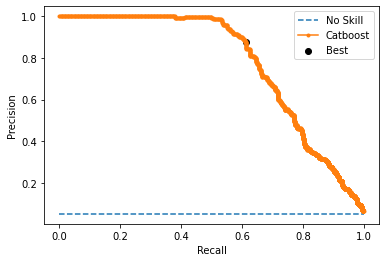

In [142]:
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Catboost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.388693, F-Score=0.725


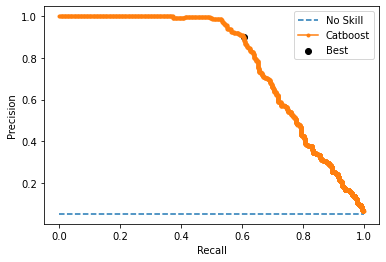

In [143]:
precision, recall, thresholds = precision_recall_curve(y_test, model2.predict_proba(X_test)[:,1])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Catboost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.374080, F-Score=0.726


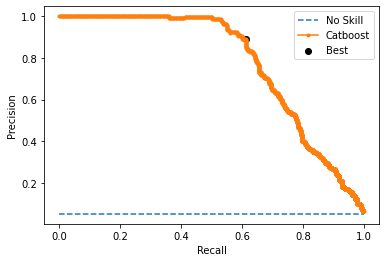

In [144]:
precision, recall, thresholds = precision_recall_curve(y_test, model3.predict_proba(X_test)[:,1])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Catboost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.290363, F-Score=0.724


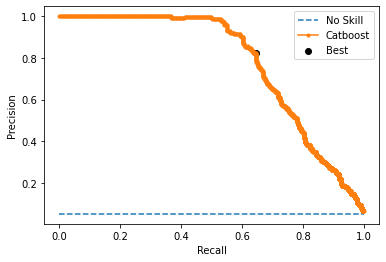

In [145]:
precision, recall, thresholds = precision_recall_curve(y_test, model4.predict_proba(X_test)[:,1])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Catboost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.363545, F-Score=0.724


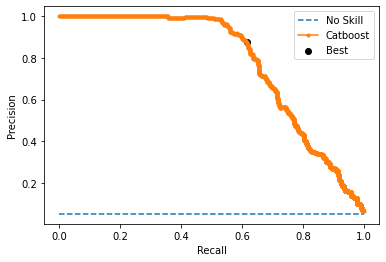

In [146]:
precision, recall, thresholds = precision_recall_curve(y_test, model5.predict_proba(X_test)[:,1])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Catboost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [147]:
test['test_prob'] = model3.predict_proba(test)[:,1]

In [148]:
test['buy'] = np.where(test['test_prob']>=0.374080,1,0)

In [149]:
test[['id','buy']].to_csv('/content/drive/MyDrive/ml competition/av-job-a-thon-june22/catboost_base12.csv',index=False)

In [150]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [151]:
import shap

/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:108: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  long_ = _make_signed(np.long)
/usr/local/lib/python3.7/dist-packages/numba/core/types/__init__.py:109: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need t

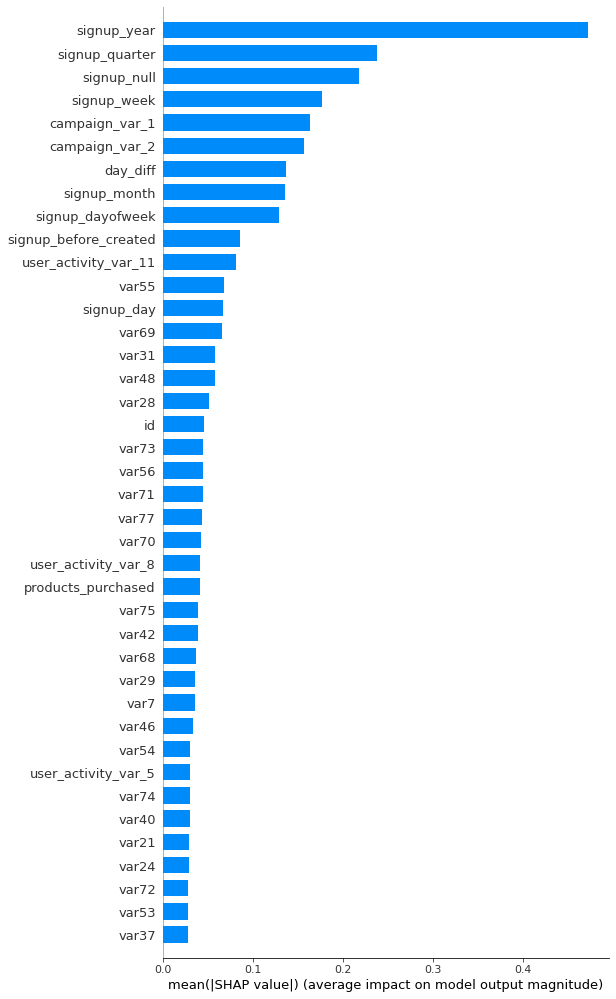

In [152]:
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar',max_display=40)

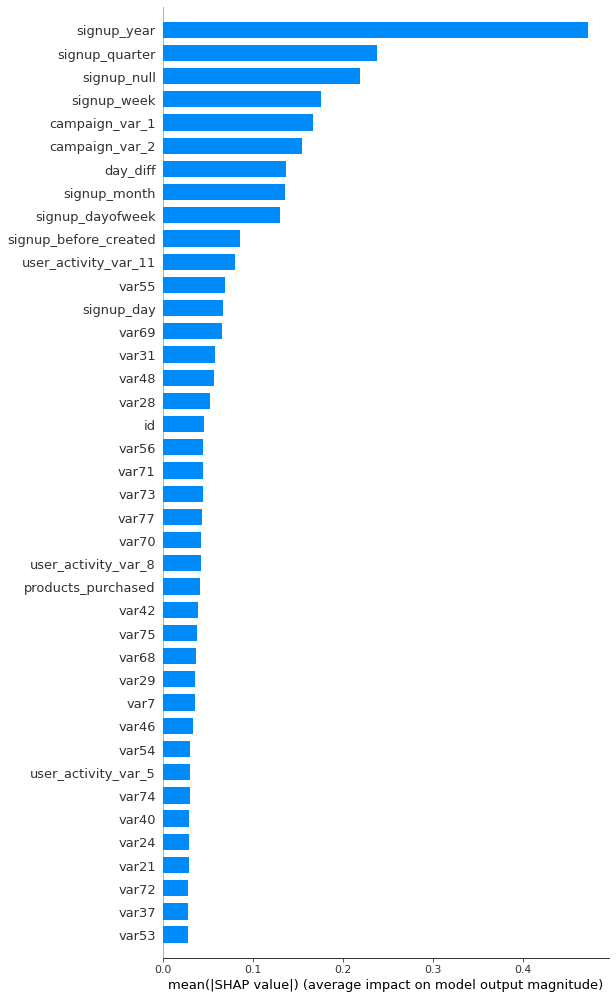

In [153]:
explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar',max_display=40)

### Without ID

In [ ]:
X_train2 = X_train.drop(columns =['id'])
X_test2 = X_test.drop(columns =['id'])

X_test2 = X_test2[X_train2.columns]
test2 = test[X_train2.columns]

In [ ]:
#catboost model training
model6 = CatBoostClassifier(n_estimators = 5000,
                        random_strength = 10,
                        max_depth = 5,
                       learning_rate = 0.01,
                        rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       l2_leaf_reg = 15,
                        use_best_model = True,
                        bagging_temperature = 5,
                       cat_features = cat_features2
                       )

In [ ]:
model6.fit(X_train2,y_train, eval_set = (X_test2,y_test), verbose=200, early_stopping_rounds= 100)

0:	learn: 0.6763041	test: 0.6763413	best: 0.6763413 (0)	total: 212ms	remaining: 17m 38s
200:	learn: 0.1088746	test: 0.1080863	best: 0.1080863 (200)	total: 38.7s	remaining: 15m 22s
400:	learn: 0.0940484	test: 0.0925657	best: 0.0925657 (400)	total: 1m 16s	remaining: 14m 32s
600:	learn: 0.0911229	test: 0.0894142	best: 0.0894142 (600)	total: 1m 56s	remaining: 14m 11s
800:	learn: 0.0892556	test: 0.0875220	best: 0.0875220 (800)	total: 2m 32s	remaining: 13m 19s
1000:	learn: 0.0880562	test: 0.0864179	best: 0.0864179 (1000)	total: 3m 10s	remaining: 12m 40s
1200:	learn: 0.0854785	test: 0.0842574	best: 0.0842574 (1200)	total: 3m 50s	remaining: 12m 8s
1400:	learn: 0.0825115	test: 0.0824583	best: 0.0824583 (1400)	total: 4m 34s	remaining: 11m 44s
1600:	learn: 0.0811512	test: 0.0818036	best: 0.0818036 (1600)	total: 5m 16s	remaining: 11m 11s
1800:	learn: 0.0802761	test: 0.0814299	best: 0.0814299 (1800)	total: 6m 1s	remaining: 10m 42s
2000:	learn: 0.0796057	test: 0.0812473	best: 0.0812473 (2000)	total:

Best Threshold=0.383193, F-Score=0.731


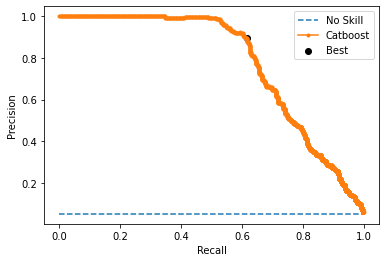

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, model6.predict_proba(X_test2)[:,1])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Catboost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [ ]:
test['test_prob'] = model6.predict_proba(test2)[:,1]

In [ ]:
test['buy'] = np.where(test['test_prob']>=0.383193,1,0)

In [ ]:
test[['id','buy']].to_csv('/content/drive/MyDrive/ml competition/av-job-a-thon-june22/catboost_base8_extended.csv',index=False)

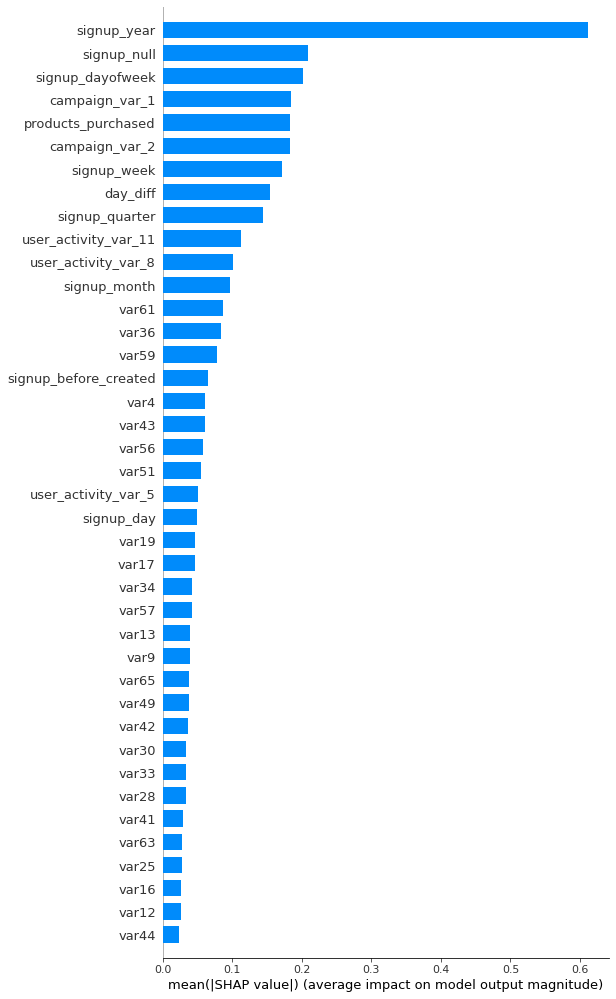

In [ ]:
explainer = shap.TreeExplainer(model6)
shap_values = explainer.shap_values(X_train2)
shap.summary_plot(shap_values, X_train2, plot_type='bar',max_display=40)

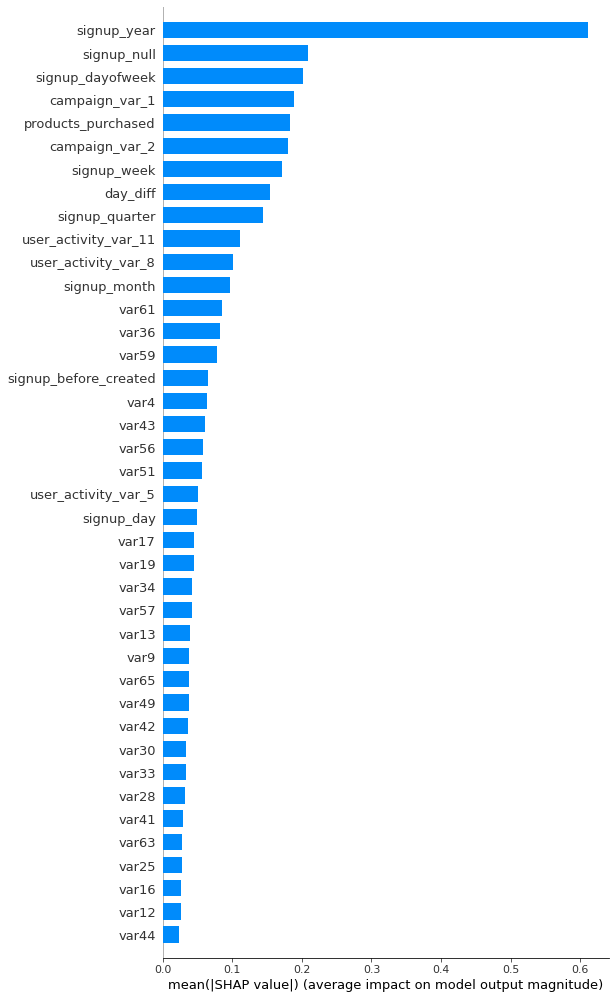

In [ ]:
explainer = shap.TreeExplainer(model6)
shap_values = explainer.shap_values(X_test2)
shap.summary_plot(shap_values, X_test2, plot_type='bar',max_display=40)